In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

import matplotlib.pyplot as plt

from utils import get_data
from tqdm import tqdm
import time

import random

# seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
import os
from openai import OpenAI
openai_api_key = os.getenv("OPENAI_KEY")

client = OpenAI(api_key = openai_api_key)

In [39]:
transform=transforms.Compose([
    transforms.ToTensor(),
])
train_ds = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_ds = datasets.MNIST('../data', train=False,
                    transform=transform)

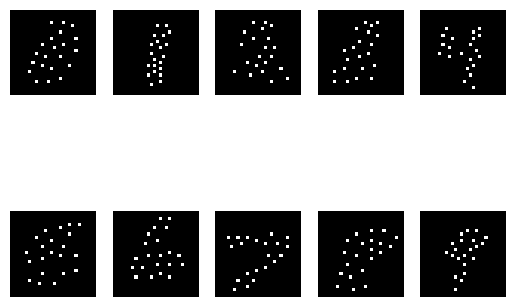

In [41]:
indices = [t for t in range(len(train_ds))]
random.shuffle(indices)

x = []
for i in range(10):
    for j in indices:
        val = train_ds[j][1]
        if val == i:
            img, _, coords, coords_str = get_data(train_ds[j])
            x.append((img, coords, val, coords_str))
            break

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = np.zeros((28, 28))
    coords = x[i][1]
    for coord in coords:
        img[coord[0], coord[1]] = 1

    plt.imshow(img, cmap='gray')
    # plt.imshow(x[i][0].reshape(28, 28), cmap='gray')
    # plt.title(x[i][2])
    plt.axis('off')    

ValueError: cannot reshape array of size 784 into shape (14,14)

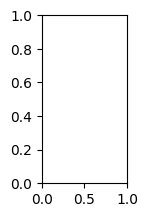

In [42]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = np.zeros((28, 28))
    coords = x[i][1]
    for coord in coords:
        img[coord[0], coord[1]] = 1

    # plt.imshow(img, cmap='gray')
    plt.imshow(x[i][0].reshape(28, 28), cmap='gray')
    # plt.title(x[i][2])
    plt.axis('off') 

In [5]:
def generate_message(value: str):
    import re
    instruction = """
Given (x, y) coordinates of non-zero pixels in a 28x28 grayscale image representing a digit, classify the digit between 0 and 9. 
Input format: "(x0,y0);(x1,y1);(x2,y2);..." with coordinates sorted first in the x-axis and then in the y-axis. 
PLEASE RETURN ONLY the digit number in brackets, e.g., if the digit is 3, return "(3)".
"""

    examples = """
Examples:
(0): (4,18);(22,7);(17,20);(11,9);(21,14);(10,21);(7,13);(16,7);(8,17);(14,22);(19,17);(23,11);(7,20);(10,12);(19,8);(5,15);(14,9);(8,11);(9,14);(12,20);(21,9);
(1): (3,14);(22,11);(17,20);(12,13);(7,10);(17,14);(21,17);(8,15);(20,14);(5,12);(5,15);(7,13);(9,9);(10,14);(14,14);(18,12);(18,18);(19,16);(22,15);(9,11);(19,20);
(2): (8,4);(19,23);(24,10);(7,17);(17,15);(13,20);(6,10);(22,16);(19,11);(9,13);(18,19);(9,8);(11,17);(6,14);(16,22);(23,13);(6,7);(9,19);(15,18);(20,14);(5,12);
(3): (4,15);(23,10);(15,19);(12,11);(6,8);(21,16);(9,16);(19,8);(19,19);(5,11);(12,15);(22,13);(12,18);(6,17);(10,14);(5,13);(12,13);(17,19);(19,17);(21,8);(21,10);
(4): (7,21);(16,4);(21,20);(6,9);(15,13);(14,23);(11,6);(16,18);(18,9);(11,19);(15,7);(17,21);(9,9);(11,22);(13,4);(14,20);(17,15);(6,19);(8,7);(9,20);(15,16);
(5): (5,22);(24,4);(19,18);(8,8);(21,11);(13,14);(6,15);(9,12);(15,18);(24,8);(9,17);(19,14);(5,18);(6,11);(6,20);(7,13);(11,11);(14,16);(17,17);(20,16);(22,7);
(6): (2,19);(21,12);(9,10);(14,21);(15,7);(15,14);(5,14);(19,18);(13,10);(17,10);(8,13);(13,18);(20,15);(5,17);(17,21);(3,16);(11,9);(12,20);(14,16);(15,19);(17,13);
(7): (5,13);(24,8);(16,16);(10,17);(21,13);(6,9);(13,16);(7,15);(18,14);(22,10);(12,18);(5,11);(7,13);(9,15);(24,10);(6,12);(6,14);(8,16);(11,16);(14,17);(20,12);
(8): (4,14);(23,13);(14,17);(11,8);(7,20);(19,18);(11,13);(17,13);(10,17);(7,12);(20,12);(22,16);(14,14);(9,10);(8,18);(12,10);(12,15);(16,18);(6,14);(12,17);(20,16);
(9): (6,13);(25,20);(17,9);(14,18);(8,19);(11,8);(20,17);(14,13);(8,10);(10,16);(14,7);(7,16);(17,17);(22,19);(9,12);(11,18);(12,15);(13,9);(15,10);(16,12);(10,10);
"""    
    # remove newlines and extra spaces
    instruction = "".join(instruction.strip().split("\n"))
    examples = "".join(examples.strip())

    instruction += "\n\n" + examples

    instruction += "\n\nInput:\n"

    instruction += value

    messages = [
        {
            "role": "user",
            "content": instruction
        }
    ]
    return messages

In [6]:
img, val, coords, coords_str = get_data(test_ds[0])
# plt.imshow(img, cmap='gray')
print(f"The number is {val}")
print(f"The coordinates are: \n{coords_str}")

The number is 7
The coordinates are: 
(8,21);(26,10);(7,6);(18,17);(10,13);(13,19);(20,12);(24,14);(9,17);(7,10);(14,16);(21,15);(23,11);(9,8);(11,21);(18,14);(8,12);(8,15);(10,19);(12,17);(15,18);


In [ ]:
img = np.zeros((28, 28))
for i in range(len(coords)):
    img[coords[i][0], coords[i][1]] = 1
plt.imshow(img, cmap='gray')

In [ ]:
temp_message = generate_message(coords_str)
print(temp_message[0]['content'])

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=temp_message,
    temperature=1.0,
)
response = response.choices[0].message.content

In [ ]:
total_length = len(test_ds)
sample_size = 100

sample_indices = np.random.choice(total_length, sample_size, replace=False)

inputs = []
for idx in tqdm(sample_indices):
    img, val, coords, coords_str = get_data(test_ds[idx])
    inputs.append((val, coords_str))

In [ ]:
print(len(inputs))
# save the inputs as .npy file
np.save("inputs.npy", inputs)

In [ ]:
predictions = []

In [ ]:
i = len(predictions)
for val, coords_str in tqdm(inputs[i:]):
    temp_message = generate_message(coords_str)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=temp_message,
        temperature=1.0,
    )
    response = response.choices[0].message.content
    predictions.append(response)

    time.sleep(1)
    

In [ ]:
print(len(predictions))

In [ ]:
# save the predictions as .npy file
predictions_int = [int(x[1:-1]) for x in predictions]


In [ ]:
y_gt = [x[0] for x in inputs]
y_pred = predictions_int[:]

print(y_gt[:10], y_pred[:10])

In [ ]:
print(f"Accuracy: {np.mean(np.array(y_gt) == np.array(y_pred))}")

# make a confusion matrix
confusion_matrix = np.zeros((10, 10))
for gt, pred in zip(y_gt, y_pred):
    confusion_matrix[gt, pred] += 1

confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)
# color the confusion matrix
# plot with values
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='viridis')
for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f"{int(100 * val)}", ha='center', va='center', color='white')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
img, val, coords, coords_str = get_data(test_ds[sample_indices[120]])

print(f"The number is {val}")
img = np.zeros((28, 28))
for i in range(len(coords)):
    img[coords[i][0], coords[i][1]] = 1
plt.imshow(img, cmap='gray')